In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [53]:
import glob
import pickle
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

def read_n_images(dataset, start, end, loc):
    assert glob.glob(loc), "Check directory."
    images_list = list(zip(*dataset[start:end]))[0]
    labels_list = list(zip(*dataset[start:end]))[1]
    labels_list = np.array(labels_list).nonzero()[-1] # Convert dummy encoding to categorical (one number per category)
    images = [cv2.imread("{}/{}.jpg".format(loc, image)) for image in images_list]
    return np.array(images), labels_list

def generate_img_from_folder(data_dir, mode, batch_size, autoencoder=True):
    """must be jpg"""
    loc = "{}/{}".format(data_dir,mode)    
    while True:
        with open('{}/labels.pickle'.format(data_dir), 'rb') as f:
            data = pickle.load(f)

        modes = list(data.keys())
        del modes[-1]
        
        assert mode in modes, "'{}' not a valid mode (must be one of {})".format(mode, str(modes))
        assert glob.glob(loc), "Check directory."
        assert glob.glob("{}/*.jpg".format(loc)), "Check file extension (should be 'jpg')."
        
        
        for idx in range(0,len(data[mode]), batch_size):
            start = idx
            end = idx+batch_size
            
            images, labels = read_n_images(data[mode], start, end, loc)

            if autoencoder:
                yield (images/255, images/255) # would be label if not autoencoder
            else:
                yield (images/255, labels) # For classification (can't classify two images at once)
                
                
def get_input_shape(data_dir, mode):
    """must be jpg"""
    loc = "{}/{}".format(data_dir,mode)
    with open('{}/labels.pickle'.format(data_dir), 'rb') as f:
        data = pickle.load(f)
   
    modes = list(data.keys())
    del modes[-1]
    assert mode in modes, "'{}' not a valid mode (must be one of {})".format(mode, str(modes))
    assert glob.glob(data_dir), "Check directory."
    idx = 0 # Arbitrarily chosen
    img = cv2.imread("{}/{}.jpg".format(loc, data[mode][idx][0]))
    return img.shape

def get_num_examples(data_dir, mode):
    with open('{}/labels.pickle'.format(data_dir), 'rb') as f:
        data = pickle.load(f)
    
    modes = list(data.keys())
    del modes[-1]
    assert mode in modes, "'{}' not a valid mode (must be one of {})".format(mode, str(modes))
    assert glob.glob(data_dir), "Check directory."
    return len(data[mode])

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist_data = pd.DataFrame(history.history).columns
    hist['epoch'] = history.epoch

    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel('Epoch')
    plt.ylabel(hist_data[1])
    for data in hist_data:
        plt.plot(hist['epoch'], hist[data], label=data)
    #plt.ylim([20,40])
    plt.title("Epochs vs. Performance")
    plt.grid()
    plt.legend()
    plt.show()

In [28]:
DATA_DIR = '../data'
MODE = 'training'
in_shape = get_input_shape(DATA_DIR, MODE)



input_img = Input(shape=in_shape)  # adapt this if using `channels_first` image data format
#input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [29]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mean_squared_error'])


In [30]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 8)         0         
__________

In [32]:
BATCH_SIZE_TRAIN = 10
NUM_SAMPLES_TRAIN = get_num_examples(DATA_DIR, 'training')
STEPS_PER_EPOCH = ceil(NUM_SAMPLES_TRAIN/BATCH_SIZE_TRAIN)

BATCH_SIZE_VAL= 10
NUM_SAMPLES_VAL = get_num_examples(DATA_DIR, 'validation')
VALIDATION_STEPS=ceil(NUM_SAMPLES_VAL/BATCH_SIZE_VAL)

EPOCHS = 1

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = autoencoder.fit_generator(generate_img_from_folder(DATA_DIR, 'training', BATCH_SIZE_TRAIN), shuffle=True,
                                    validation_data=generate_img_from_folder(DATA_DIR, 'validation', BATCH_SIZE_VAL),
                                    steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS,
                                    epochs=EPOCHS)


162/162 [==============================] - 365s 2s/step - loss: 5.7091 - acc: 0.0223 - val_loss: 5.6435 - val_acc: 0.0206


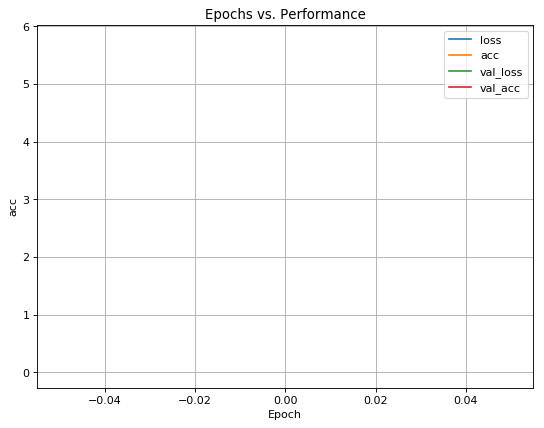

In [55]:
plot_history(history)